In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import galois

from bposd.hgp import hgp
import time
from QLPDC_decoder import *

# concatonated QLPDC code thresholds:

* We want to look at the performance of the cluster decoder on concatonated QLDPC codes as a function of, $n$, the number of qubits in the inner code.

### Lets build QLDPC code $[[18n^2, 4,2n]]$ from HGP of $[3(n),2,2(n)]$

First lets build the outer classical code: $[3(n),2,2(n)]$

In [5]:
def cLDPC(n):
    H = np.zeros((3*n-2,3*n), dtype=int)
    for i in range(2*n-1):
        H[i][i] = 1
        H[i][i+1] = 1
    
    for i in range(2*n-1,3*n-2):
        H[i][i+1] = 1
        H[i][i+2] = 1
    H[n-1][2*n]=1

    return H

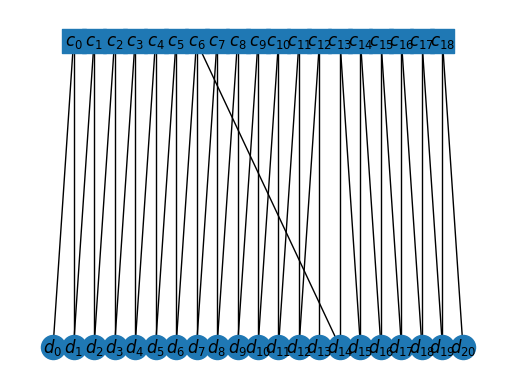

In [6]:
H1 = cLDPC(7)
T1 = tanner_graph(H1)
draw_tanner_graph(T1)

# Next we form the quantum code from the hyper-graph product:

In [7]:
Hn = cLDPC(4)
qcodeN=hgp(Hn,Hn,compute_distance=True)
qcodeN.test()
HNx = qcodeN.hx
TNx = tanner_graph(HNx)

<Unnamed CSS code>, (3,5)-[[244,4,8]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (3,5)-[[244,4,8]]


# Threshold simulation
Now lets consider the performance of these codes as we scale up the size of the repetition code:

In [14]:
N_list = [2, 3, 4]
p_list = [.002, .005, .01, .015, .02, .03,.05]
threshold_dic = {}

for N in N_list:
    threshold_dic[N] = []

In [15]:
t0 = time.time()

runs = 10**4
qubits_dict = {}


for N in N_list:
    Hn = cLDPC(N)
    qcodeN=hgp(Hn,Hn,compute_distance=True)
    qcodeN.test()
    HNx = qcodeN.hx
    TNx = tanner_graph(HNx)

    qubits_dict[N] = qcodeN.N


    for p in p_list:
        n_incorrect = 0
        n_decode = 0
        for i in range(runs):

            x_error = np.random.binomial(1,p,HNx.shape[1])

            syndrome = HNx@x_error %2
            e_estimate, final_clusters = my_ldpc_decoder(TNx, syndrome)

            for n, L in enumerate(qcodeN.lz):
                if ((x_error+e_estimate) @ L %2).any():
                    n_incorrect +=1
                    break
            
            if i % int(runs/2) ==0:
                print(f'there are {len(final_clusters)} clusters')
                print(f'{n_incorrect} wrong after run {i}')
                print(f'run {i} for p = {p} at time {time.time()-t0}')
                print('==============================================')

        threshold_dic[N].append(n_incorrect/runs)
        
        print(f'Fraction incorrect {n_incorrect/runs:0.3f}')
        print(f'failed to decode {n_decode/runs}')
    print(f'done with size {N}')

<Unnamed CSS code>, (3,5)-[[52,4,4]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (3,5)-[[52,4,4]]
there are 0 clusters
0 wrong after run 0
run 0 for p = 0.002 at time 0.004915952682495117
there are 0 clusters
112 wrong after run 5000
run 5000 for p = 0.002 at time 0.7595689296722412
Fraction incorrect 0.021
failed to decode 0.0
there are 1 clusters
0 wrong after run 0
run 0 for p = 0.005 at time 1.4679460525512695
there are 1 clusters
271 wrong after run 5000
run 5000 for p = 0.005 at time 3.175790786743164
Fraction incorrect 0.051
failed to decode 0.0
there are 0 clusters
0 wrong after run 0
run 0 for p = 0.01 at time 4.835752010345459
there are 0 clusters
486 wrong after run 5000
run 5000 for p = 0.01 at time 8.269599914550781
Fraction incorrect 0.099
failed to decode 0.0
there are 1 clusters
0 wrong after run 0
run 0 

### Lets plot this data:

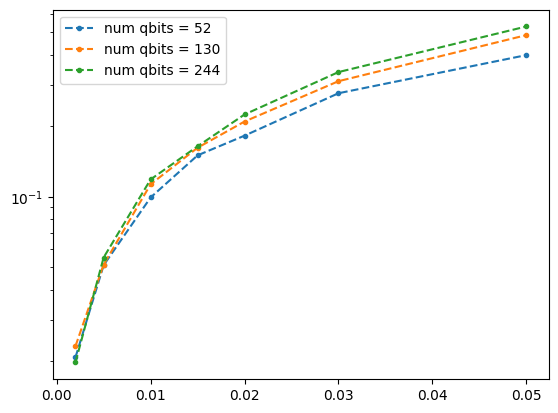

In [16]:
for N in N_list:
    plt.plot(p_list,threshold_dic[N], '.--',label = f'num qbits = {qubits_dict[N]}')
plt.legend()
plt.yscale('log')

## Comparisson with BP+OSD decoder:

In [17]:
from ldpc import bposd_decoder
from ldpc.codes import rep_code
from bposd.hgp import hgp

### To see how this work let's consider the code built from $n=4$ repition codes

<Unnamed CSS code>, (3,5)-[[244,4,8]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (3,5)-[[244,4,8]]


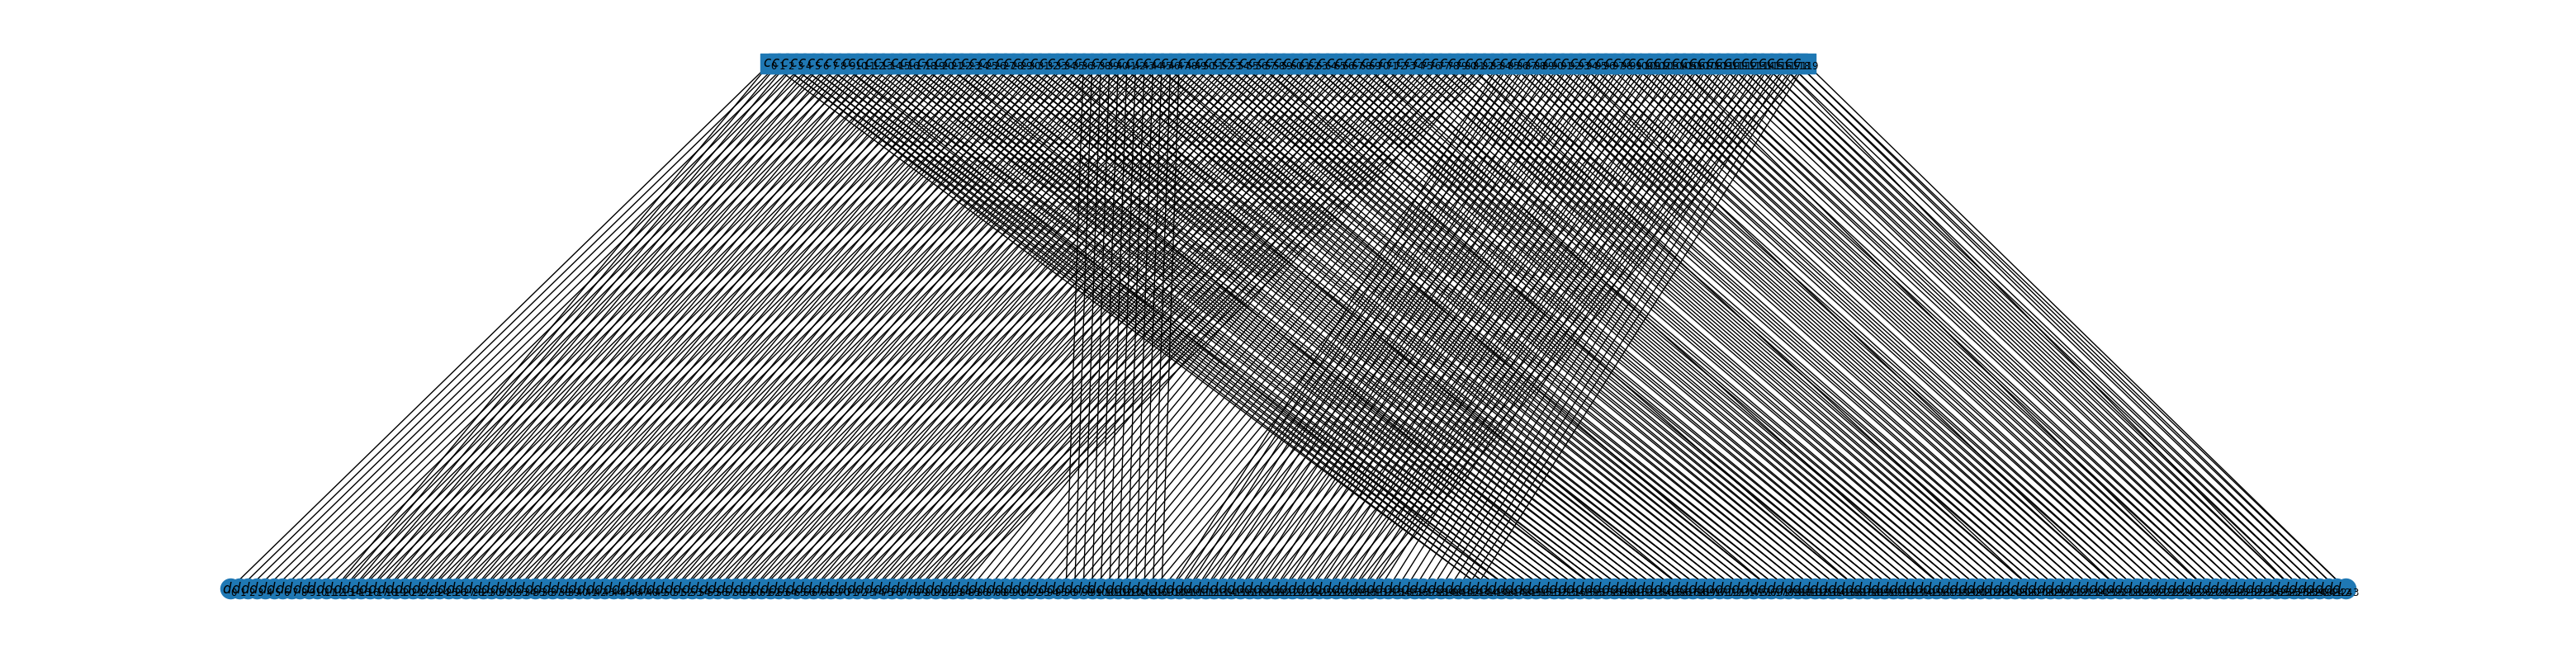

In [18]:
Hn = cLDPC(4)
qcodeN=hgp(Hn,Hn,compute_distance=True)
qcodeN.test()
HNx = qcodeN.hx
TNx = tanner_graph(HNx)

plt.figure(figsize=(40,10))
draw_tanner_graph(TNx)

In [19]:
bpd=bposd_decoder(
    qcodeN.hx,#the parity check matrix
    error_rate=0.05,
    channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=qcodeN.N, #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=7 #the osd search depth
    )

In [20]:
error = np.random.binomial(1,.05, qcodeN.N).astype(int)
syndrome=qcodeN.hx@error %2
bpd.decode(syndrome)

print("Error")
print(error)
print("BP+OSD Decoding")
print(bpd.osdw_decoding)
#Decoding is successful if the residual error commutes with the logical operators
residual_error=(bpd.osdw_decoding+error) %2
a=(qcodeN.lx@residual_error%2).any()
if a: a="Yes"
else: a="No"
print(f"Logical Error: {a}\n")

Error
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
BP+OSD Decoding
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# Same monte-carlo as cluster decoder:
* sweep over $n$ and $p$
* compare to the cluster decoder above

In [27]:
threshold_bp_dic = {}

for N in N_list:
    threshold_bp_dic[N] = []

In [28]:
for N in N_list:
    Hn = cLDPC(N)
    qcodeN=hgp(Hn,Hn,compute_distance=True)
    HNx = qcodeN.hx
    TNx = tanner_graph(HNx)


    for p in p_list:
        n_incorrect = 0
        n_decode = 0

        bpd=bposd_decoder(
        qcodeN.hx,#the parity check matrix
        error_rate= p,
        channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
        max_iter=2*qcodeN.N, #the maximum number of iterations for BP)
        bp_method="ms",
        ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
        osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
        osd_order=7 #the osd search depth
        )

        for i in range(5*runs):
            error = np.random.binomial(1,p, qcodeN.N).astype(int)
            syndrome=qcodeN.hx@error %2
            bpd.decode(syndrome)

            residual_error=(bpd.osdw_decoding+error) %2
            if (qcodeN.lx@residual_error%2).any():
                n_incorrect+=1
                
        threshold_bp_dic[N].append(n_incorrect/(5*runs))
        print(f'done with {p} for size {N}')

           

done with 0.002 for size 2
done with 0.005 for size 2
done with 0.01 for size 2
done with 0.015 for size 2
done with 0.02 for size 2
done with 0.03 for size 2
done with 0.05 for size 2
done with 0.002 for size 3
done with 0.005 for size 3
done with 0.01 for size 3
done with 0.015 for size 3
done with 0.02 for size 3
done with 0.03 for size 3
done with 0.05 for size 3
done with 0.002 for size 4
done with 0.005 for size 4
done with 0.01 for size 4
done with 0.015 for size 4
done with 0.02 for size 4
done with 0.03 for size 4
done with 0.05 for size 4


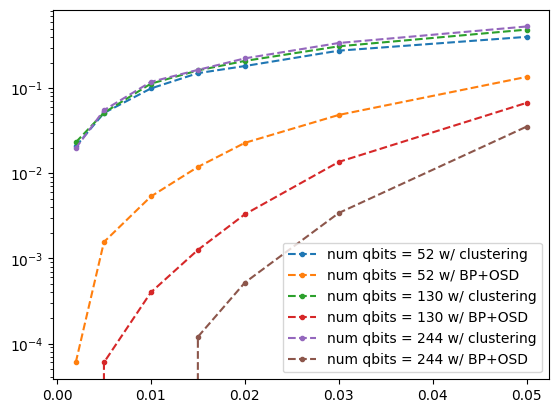

In [29]:
for N in N_list:
    plt.plot(p_list,threshold_dic[N], '.--',label = f'num qbits = {qubits_dict[N]} w/ clustering')
    plt.plot(p_list,threshold_bp_dic[N], '.--',label = f'num qbits = {qubits_dict[N]} w/ BP+OSD')
plt.legend()
plt.yscale('log')

### We can see that the BP decoder is much better than the cluster decoder